# The Doppler Observation Equation

## Objectives
* Treatment and mitigation of (common) errors and biases that affect DORIS observations
* Formulation of a (simplified) observation equation 

## Section 1 - Import/Initialize

*import modules ...* everything we are going to need (and have already talked about).

In [52]:
# Section 1 - Imports
# -------------------

# imports
import datetime
import attotime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from os.path import join
import copy

# DSO modules
from dsoclasses.doris.algorithms import beacon_nominal_frequency, starec_pcv
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt, fsec2asec, to_attoseconds
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.gnss import algorithms as alg
from dsoclasses.troposphere.vmf3 import SiteVmf3
from dsoclasses.sinex import sinex

*define paths, files and data streams ....*

In [53]:
# Section 1.1 – Define Files needed for analysis
# -----------------------------------------------
data_path = "../../../data"
drinex = join(data_path, "s6arx24001.001")
dpod = join(data_path, "dpod2020_041.snx")
dpod_freq_corr = join(data_path, "dpod2020_041_freq_corr.txt")
dsp3 = join(data_path, "ssas6a20.b23357.e24001.DG_.sp3.001")
vmf3_data = join(data_path, "y2024.vmf3_d")

*initialize an orbit interpolator ...*

In [54]:
# Section 1.2 - Load Orbit Data + Initialize Interpolator
# -------------------------------------------------------
intrp = interpolator.Sp3Interpolator.from_sp3(dsp3, ['L'], interval_in_sec=310, min_data_pts=10, itype='Barycentric')
sat_id = list(intrp._interpolators.keys())[0]

*initialize the DORIS RINEX stream, choose a site/beacon and get its coordinates ...*

In [55]:
# Section 1.3 - Intitialize DorisRinex and select a beacon (Dionysos/DIOB)
# ------------------------------------------------------------------------

rnx = DorisRinex(drinex)
# site_name = 'DIOB'
# site_name = 'TLSB'
site_name = 'KOLB'
result = sinex.extract_sinex_coordinates(dpod, [site_name], rnx.time_first_obs, True, dpod_freq_corr)
rsta = np.array([result[site_name]['X'], result[site_name]['Y'], result[site_name]['Z']])
# we are also going to need the geodetic coordinates of the site
lat, lon, hgt = transformations.car2ell(*rsta)

*initialize a `SiteVmf3` instance ...*

In [56]:
# Section 1.4 - Initialize VMF3 from (DORIS) site data
# ----------------------------------------------------
vmf = SiteVmf3(vmf3_data, [site_name])

In [57]:
# Section 1.5 - Harsh outlier removal
# ----------------------------------------------------
def filter_outliers(residuals, a2_list, a3_list):
    a1_np, a2_np, a3_np = map(np.asarray, (residuals, a2_list, a3_list))
    
    z = (a1_np - a1_np.mean()) / a1_np.std(ddof=1)  # z-scores
    mask = np.abs(z) <= 3
    
    a1_clean = a1_np[mask].tolist()
    a2_clean = a2_np[mask].tolist()
    a3_clean = a3_np[mask].tolist()
    return a1_clean, a2_clean, a3_clean

## Section 2 - Forming Doppler Observation Equation

We will use the following formulation of the Doppler Observation Equation for the following:
$$
\frac{c}{f_{eN}} \cdot (f_{eN} - f_{rT} - \frac{\phi (t_2) - \phi (t_1)}{\Delta t})
\approx \frac{\rho (t_2) - \rho (t_1)}{\Delta t}
$$

- $\phi (t_i)$ is the carrier wave phase observation at instant $t_i$,
- $\Delta t$ time interval, in seconds, between $t_2$ and $t_1$,
- $c$ speed of light,
- $f_{eN}$ nominal emmiter (i.e. beacon) frequency,
- $f_{rT}$ "true" receiver (i.e. satellite) frequency, and
- $\rho _{t_i}$ range (satellite-beacon distance) at $t_i$

In the following sections, we will gradually mitigate/treat error sources that affect DORIS Doppler observations, and see the effect on computed residuals.

### 2.1 Receiver Clock Errors

Clock synchronization errors are very important in every satellite technique where time is measured by a different oscillator at the two ends (receiver/beacon). In the case of DORIS RINEX, the receiver (satellite) clock error w.r.t. DORIS system time (i.e. TAI) is reported for each block. We can use this value to 'correct' our observations from the clock error at the receiver end. Note that a similar error at the transmitting end (i.e. the beacon) can only be estimated.

Let's go on and remove this error to see its effect on the residuals.

In [58]:
# Section 2.1 – Preprocess Doppler observations on L2GHz
# ------------------------------------------------------

# Helper variables to assist analysis
tai_prev = None     # time of last observation if any [TAI]
cp_prev = None      # Last carrier phase observation value (at tai_prev), [cycles]
rsat_prev = None    # Last satellite position, ECEF [m]
pass_nr = 0         # current pass index

# globals
CUTOFF_ANGLE = np.radians(1.) # cut-off angle in [deg]
C = 299792458e0 # speed of light in vacuum, [m/sec]

# nominal transmitting frequencies for selected beacon
# s1 -> 2GHz   channel
# u2 -> 400MHz channel
s1, u2 = beacon_nominal_frequency(rnx.kfactor(site_name))

# set emitter nominal (feN) and receiver nominal (frN) frequencies to s1
feN = frN = frT = s1

# store results here
residuals = []; epochs = []; elevations = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            # this is the actual epoch of observation
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # see if we have a new pass !
            # we define a new pass to take place if we have a previous data gap of
            # 300 sec.
            # Note that the initial pass is numbered as 0 (not 1)
            if tai_prev is None or (tai-tai_prev).total_seconds() > 300.:
                pass_nr += 1 if pass_nr > 0 else 0
            
            # Satellite position at signal reception time; store into an array
            satx, saty, satz, _ = intrp.sat_at(sat_id, tai)
            rsat = np.array([satx, saty, satz])

            # compute elevation
            _, _, el = transformations.azele(rsat, rsta)

            # only consider the observation if above cut-off angle
            if el >= CUTOFF_ANGLE:
    
                # Phase measurements at 2GHz carrier
                L2ghz = data['L1']['value']

                # form the Doppler observation, if we have a previous measurement, within 10 sec ...
                # remember, this is current - previous
                if tai_prev is not None and (tai-tai_prev).total_seconds() <= 10.:
                    # delta time between this and previous obs, in [sec]
                    dt = float((tai-tai_prev).total_nanoseconds()) * 1e-9
                    # measured part of the obs. equation
                    rr_observed = -(C / feN) * (feN - frT - (L2ghz-cp_prev)/dt)
                    # computed part of the obs. equation
                    rr_computed = (np.linalg.norm(rsat-rsta) - np.linalg.norm(rsat_prev-rsta)) / dt
                    # store results
                    residuals.append(rr_observed-rr_computed)
                    epochs.append(tai)
                    elevations.append(el)

                # prepare for next measurement
                tai_prev    = tai
                cp_prev     = L2ghz
                rsat_prev   = rsat

# short report
print("Doppler Obs. Equation Residuals on the 2GHz Channel")
print("----------------------------------------------------")
print(f"Number of Doppler observations extracted: {len(residuals)}")
print(f"Residal mean value: {np.mean(residuals):.1f} and std. deviation = {np.std(residuals):.2f}")

# Optional; remove outliers
residuals, epochs, elevations = filter_outliers(residuals, epochs, elevations)

# keep residuals for reference
residuals_sec21 = residuals; epochs_sec21 = epochs; elevations_sec21 = elevations;

Doppler Obs. Equation Residuals on the 2GHz Channel
----------------------------------------------------
Number of Doppler observations extracted: 1038
Residal mean value: 105.8 and std. deviation = 2002.36


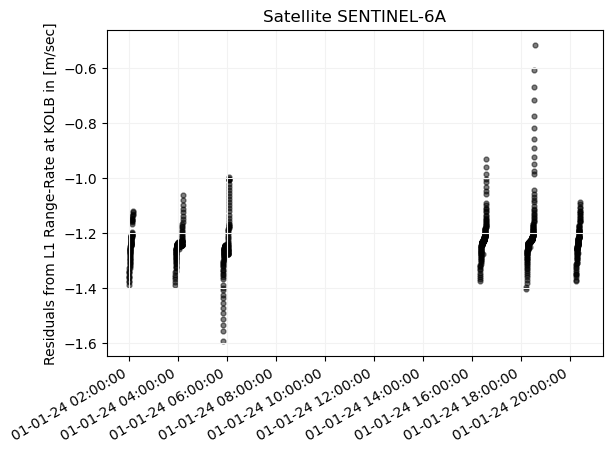

In [59]:
# Section 2.1-1 - Residual plot vs Time

plt.scatter([at2pt(ti) for ti in epochs], residuals, alpha=0.5, s=12, c='black')

plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()

# plt.ylim(92.6, 130.0)
plt.show()

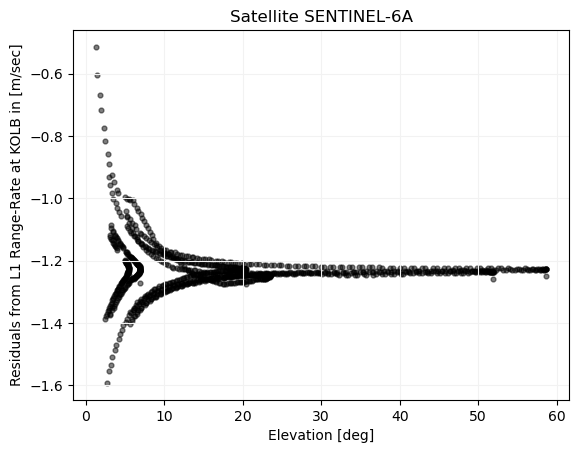

In [60]:
# Section 2.1-2 - Residual plot vs Elevation

plt.scatter([np.degrees(el) for el in elevations], residuals, alpha=0.5, s=12, c='black')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")
plt.xlabel("Elevation [deg]")
plt.show()

### 2.2 Nominal and True Frequencies

When accuracy is needed, one can distinguish between **true** and **nominal** receiver/transmitter frequencies. Theoretically, both ends should transmit/receive at nominal frequencies but this is not the case due to small hardware effects. RINEX files provide *relative frequency offset of the receiver's oscillator*, i.e. $F=\frac{f_{rT}-f_{rN}}{f_{rN}}$ tagged as observation type 'F', for each epoch, scaled by $10^{11}$. We can use these values to modify the equation as:
$$
(\frac{\phi (t_2) - \phi (t_1)}{\Delta t} + f_{rT} - f_{eN}) \cdot \frac{c}{f_{eN}} 
\approx \frac{\rho (t_2) - \rho (t_1)}{\Delta t}
$$


Doppler Obs. Equation Residuals on the 2GHz Channel
----------------------------------------------------
Number of Doppler observations extracted: 1035
Residal mean value: -2.6 and std. deviation = 0.08


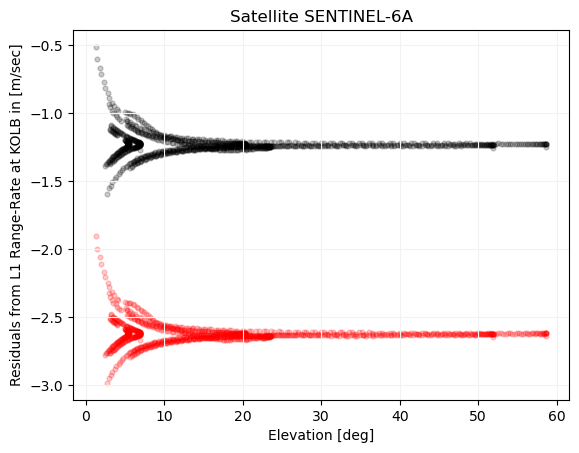

In [61]:
# Section 2.2 – Preprocess Doppler observations on L2GHz
#               Nominal and True Frequencies
# ------------------------------------------------------

# Helper variables to assist analysis
tai_prev = None     # time of last observation if any [TAI]
cp_prev = None      # Last carrier phase observation value (at tai_prev), [cycles]
rsat_prev = None    # Last satellite position, ECEF [m]
pass_nr = 0         # current pass index

# globals
CUTOFF_ANGLE = np.radians(1.) # cut-off angle in [deg]
C = 299792458e0 # speed of light in vacuum, [m/sec]

# nominal transmitting frequencies for selected beacon
# s1 -> 2GHz   channel
# u2 -> 400MHz channel
s1, u2 = beacon_nominal_frequency(rnx.kfactor(site_name))

# set emitter nominal (feN) and receiver nominal (frN) frequencies to s1
feN = frN = s1

# store results here
residuals = []; epochs = []; elevations = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            # this is the actual epoch of observation
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # see if we have a new pass !
            # we define a new pass to take place if we have a previous data gap of
            # 300 sec.
            # Note that the initial pass is numbered as 0 (not 1)
            if tai_prev is None or (tai-tai_prev).total_seconds() > 300.:
                pass_nr += 1 if pass_nr > 0 else 0
            
            # Satellite position at signal reception time; store into an array
            satx, saty, satz, _ = intrp.sat_at(sat_id, tai)
            rsat = np.array([satx, saty, satz])

            # compute elevation
            _, _, el = transformations.azele(rsat, rsta)

            # only consider the observation if above cut-off angle
            if el >= CUTOFF_ANGLE:
    
                # Phase measurements at 2GHz carrier
                L2ghz = data['L1']['value']
    
                # apply frequency offset - get true receiver frequency - frT
                frT = frN * (1 + data['F']['value'] * 1e-11)

                # form the Doppler observation, if we have a previous measurement, within 10 sec ...
                # remember, this is current - previous
                if tai_prev is not None and (tai-tai_prev).total_seconds() <= 10.:
                    # delta time between this and previous obs, in [sec]
                    dt = float((tai-tai_prev).total_nanoseconds()) * 1e-9
                    # measured part of the obs. equation
                    rr_observed = -(C / feN) * (feN - frT - (L2ghz-cp_prev)/dt)
                    # computed part of the obs. equation
                    rr_computed = (np.linalg.norm(rsat-rsta) - np.linalg.norm(rsat_prev-rsta)) / dt
                    # store results
                    residuals.append(rr_observed-rr_computed)
                    epochs.append(tai)
                    elevations.append(el)

                # prepare for next measurement
                tai_prev    = tai
                cp_prev     = L2ghz
                rsat_prev   = rsat

# Optional; remove outliers
residuals, epochs, elevations = filter_outliers(residuals, epochs, elevations)

# short report
print("Doppler Obs. Equation Residuals on the 2GHz Channel")
print("----------------------------------------------------")
print(f"Number of Doppler observations extracted: {len(residuals)}")
print(f"Residal mean value: {np.mean(residuals):.1f} and std. deviation = {np.std(residuals):.2f}")
plt.scatter([np.degrees(el) for el in elevations_sec21], residuals_sec21, alpha=0.2, s=12, c='black')
plt.scatter([np.degrees(el) for el in elevations], residuals, alpha=0.2, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")
plt.xlabel("Elevation [deg]")
# plt.ylim(2.6, 3.0)
plt.show()

# keep residuals for reference
residuals_sec22 = residuals; epochs_sec22 = epochs; elevations_sec22 = elevations;

### 2.3 Tropospheric Delay

Each carrier-phase observation $\phi (t_i)$ is affected by tropospheric delay $\delta T(t_i)$, hence to mitigate tropospheric dealy from the Doppler observation equation we have to compute
$$
\delta T_{1,2} = \frac{\delta T(t_2) - \delta T(t_1)}{\Delta t}
$$

Inserting the above into the observation equation and using $\epsilon$ to denote remaining errors, we get:
$$
\frac{c}{f_{eN}} \cdot (f_{eN} - f_{rT} - \frac{\phi (t_2) - \phi (t_1)}{\Delta t}) - \delta T_{1,2}
= \frac{\rho (t_2) - \rho (t_1)}{\Delta t} + \epsilon
$$

We can use the 2GHz channel to form Doppler observations, using consecutive phase measurements (note that in DORIS we have two obervations for every 10sec, one at 3sec and one at 7sec). To do that, we need to keep track of the previous measurement (if any) and identify different passes. Additionally, we need to know the (nominal) frequencies of the beacon (computed using the RINEX provided *frequency shift factor*).

Doppler Obs. Equation Residuals on the 2GHz Channel
----------------------------------------------------
Number of Doppler observations extracted: 1035
Residal mean value: -2.6 and std. deviation = 0.02


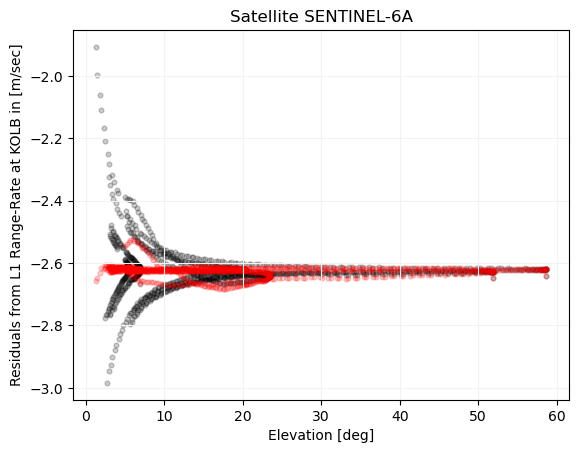

In [62]:
# Section 2.3 – Preprocess Doppler observations on L2GHz
#               Modeling tropospheric delay
# ----------------------------------------------------

# Helper variables to assist analysis
tai_prev = None     # time of last observation if any [TAI]
cp_prev = None      # Last carrier phase observation value (at tai_prev), [cycles]
dtropo_prev = None  # Last tropospheric correction [m]
rsat_prev = None    # Last satellite position, ECEF [m]
pass_nr = 0         # current pass index

# globals
CUTOFF_ANGLE = np.radians(1.) # cut-off angle in [deg]
C = 299792458e0 # speed of light in vacuum, [m/sec]

# nominal transmitting frequencies for selected beacon
# s1 -> 2GHz   channel
# u2 -> 400MHz channel
s1, u2 = beacon_nominal_frequency(rnx.kfactor(site_name))

# set emitter nominal (feN) and receiver nominal (frN) frequencies to s1
feN = frN = s1

# store results here
residuals = []; epochs = []; elevations = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            # this is the actual epoch of observation
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # see if we have a new pass !
            # we define a new pass to take place if we have a previous data gap of
            # 300 sec.
            # Note that the initial pass is numbered as 0 (not 1)
            if tai_prev is None or (tai-tai_prev).total_seconds() > 300.:
                pass_nr += 1 if pass_nr > 0 else 0
            
            # Satellite position at signal reception time; store into an array
            satx, saty, satz, _ = intrp.sat_at(sat_id, tai)
            rsat = np.array([satx, saty, satz])

            # compute elevation
            _, _, el = transformations.azele(rsat, rsta)

            # only consider the observation if above cut-off angle
            if el >= CUTOFF_ANGLE:
                # compute a-priori tropospheric delay [m]
                dtropo = vmf.tropo_delay(site_name, lat, lon, el, at2pt(tai))
    
                # Phase measurements at 2GHz carrier
                L2ghz = data['L1']['value']
    
                # apply frequency offset - get true receiver frequency - frT
                frT = frN * (1 + data['F']['value'] * 1e-11)

                # form the Doppler observation, if we have a previous measurement, within 10 sec ...
                # remember, this is current - previous
                if tai_prev is not None and (tai-tai_prev).total_seconds() <= 10.:
                    # delta time between this and previous obs, in [sec]
                    dt = float((tai-tai_prev).total_nanoseconds()) * 1e-9
                    # measured part of the obs. equation
                    rr_observed = -(C / feN) * (feN - frT - (L2ghz-cp_prev)/dt)
                    # computed part of the obs. equation
                    rr_computed = (np.linalg.norm(rsat-rsta) - np.linalg.norm(rsat_prev-rsta) + (dtropo-dtropo_prev)) / dt
                    # store results
                    residuals.append(rr_observed-rr_computed)
                    epochs.append(tai)
                    elevations.append(el)

                # prepare for next measurement
                tai_prev    = tai
                cp_prev     = L2ghz
                dtropo_prev = dtropo
                rsat_prev   = rsat

# Optional; remove outliers
residuals, epochs, elevations = filter_outliers(residuals, epochs, elevations)

# short report
print("Doppler Obs. Equation Residuals on the 2GHz Channel")
print("----------------------------------------------------")
print(f"Number of Doppler observations extracted: {len(residuals)}")
print(f"Residal mean value: {np.mean(residuals):.1f} and std. deviation = {np.std(residuals):.2f}")
plt.scatter([np.degrees(el) for el in elevations_sec22], residuals_sec22, alpha=0.2, s=12, c='black')
plt.scatter([np.degrees(el) for el in elevations], residuals, alpha=0.2, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")
plt.xlabel("Elevation [deg]")
# plt.ylim(2.6, 3.0)
plt.show()

# keep residuals for reference
residuals_sec23 = residuals; epochs_sec23 = epochs; elevations_sec23 = elevations;

### 2.4 Ionospheric Delay

We can account for the inospheric delay by using the "Iono-Free" linear combination, i.e.

$$
    L_{IF} = \frac{\gamma L_{2GHz} - \sqrt{\gamma} L_{400MHz}}{\gamma - 1}
$$

so that we now have

$$
\frac{c}{f_{eN}} \cdot (\frac{L_{IF} (t_2) - L_{IF} (t_1)}{\Delta t} + f_{eN} - f_{rT}) - \delta T_{1,2}
= \frac{\rho (t_2) - \rho (t_1)}{\Delta t} + \epsilon
$$

Doppler Obs. Equation Residuals on the 2GHz Iono-Free Channel
-------------------------------------------------------------
Nominal frequencies S1=2036.2GHz (or 0.147 m.), U2=401250.0MHz (or 0.747 m.)
Iono-Free LC frequency L3=2036.2GHz or 0.147 m.
Number of Doppler observations extracted: 1035
Residal mean value: -2.6 and std. deviation = 0.00


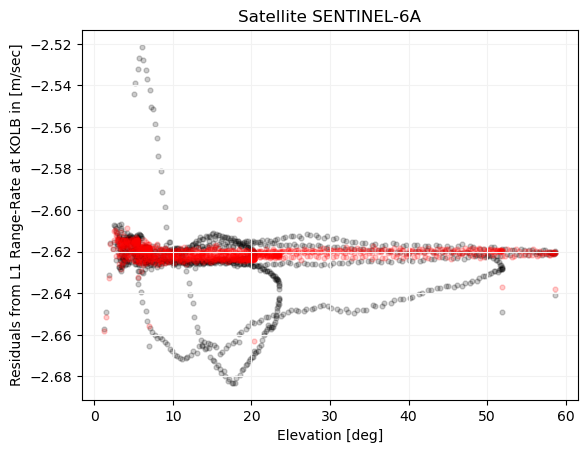

In [63]:
# Section 2.4 – Preprocess Doppler observations 
#               Mitigating iono delay
# ----------------------------------------------

# Helper variables to assist analysis
tai_prev = None     # time of last observation if any [TAI]
cp_prev = None      # Last carrier phase observation value (at tai_prev), [cycles]
dtropo_prev = None  # Last tropospheric correction [m]
rsat_prev = None    # Last satellite position, ECEF [m]
pass_nr = 0         # current pass index

# globals
CUTOFF_ANGLE = np.radians(1.) # cut-off angle in [deg]
C = 299792458e0 # speed of light in vacuum, [m/sec]

# nominal transmitting frequencies for selected beacon
# s1 -> 2GHz   channel
# u2 -> 400MHz channel
s1, u2 = beacon_nominal_frequency(rnx.kfactor(site_name))

# Nominal frequency for "Ionosphere-Free" linear combination
sqrt_gamma = s1 / u2
gamma = sqrt_gamma * sqrt_gamma
feN = frN = (gamma * s1 - sqrt_gamma * u2) / (gamma-1.)
# ... and a function to compute it based on the two channels
def iflc(L2ghz, L400mhz): return (gamma * L2ghz - sqrt_gamma * L400mhz) / (gamma-1.)
assert feN == frN

# store results here
residuals = []; epochs = []; elevations = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            # this is the actual epoch of observation
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # see if we have a new pass
            if tai_prev is None or (tai-tai_prev).total_seconds() > 300.:
                pass_nr += 1 if pass_nr > 0 else 0
            
            # Satellite position at signal reception time; store into an array
            satx, saty, satz, _ = intrp.sat_at(sat_id, tai)
            rsat = np.array([satx, saty, satz])

            # compute elevation
            _, _, el = transformations.azele(rsat, rsta)

            # only consider the observation if above cut-off angle
            if el >= CUTOFF_ANGLE:
                # compute a-priori tropospheric delay
                dtropo = vmf.tropo_delay(site_name, lat, lon, el, at2pt(tai))
    
                # Phase measurements at 2GHz and 400Mhz carriers
                L2ghz = data['L1']['value']
                L400mhz = data['L2']['value']
                # combine to an "iono-free" (virtual) phase measurement
                Lif = iflc(L2ghz, L400mhz)
    
                # apply frequency offset - get true receiver frequency
                frT = frN * (1 + data['F']['value'] * 1e-11)
    
                # if we have a previous measurement, within 10 sec ...
                if tai_prev is not None and (tai-tai_prev).total_seconds() <= 10.:
                    # delta time between this and previous obs, in [seconds]
                    dt = float((tai-tai_prev).total_nanoseconds()) * 1e-9
                    # measured part of the obs. equation
                    rr_observed = -(C / feN) * (feN - frT - (Lif-cp_prev)/dt)
                    # computed part of the obs. equation
                    rr_computed = (np.linalg.norm(rsat-rsta) - np.linalg.norm(rsat_prev-rsta) + (dtropo-dtropo_prev)) / dt
                    # store results
                    residuals.append(rr_observed-rr_computed)
                    epochs.append(tai)
                    elevations.append(el)

                # prepare for next measurement
                tai_prev    = tai
                cp_prev     = Lif
                dtropo_prev = dtropo
                rsat_prev   = rsat

# Optional; remove outliers
residuals, epochs, elevations = filter_outliers(residuals, epochs, elevations)

print("Doppler Obs. Equation Residuals on the 2GHz Iono-Free Channel")
print("-------------------------------------------------------------")
print(f'Nominal frequencies S1={s1*1e-6:.1f}GHz (or {C/s1:.3f} m.), U2={u2*1e-3:.1f}MHz (or {C/u2:.3f} m.)')
print(f'Iono-Free LC frequency L3={feN*1e-6:.1f}GHz or {C/feN:.3f} m.')
print(f"Number of Doppler observations extracted: {len(residuals)}")
print(f"Residal mean value: {np.mean(residuals):.1f} and std. deviation = {np.std(residuals):.2f}")
plt.scatter([np.degrees(el) for el in elevations_sec23], residuals_sec23, alpha=0.2, s=12, c='black')
plt.scatter([np.degrees(el) for el in elevations], residuals, alpha=0.2, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")
plt.xlabel("Elevation [deg]")
# plt.ylim(2.6, 3.0)
plt.show()

# keep residuals for reference
residuals_sec24 = residuals; epochs_sec24 = epochs; elevations_sec24 = elevations;

### 2.5 Offsets between Reference Points and Phase Centers

### Geometry of the STAREC[B|C] DORIS Ground Beacons

![Image Description](assets/starecBC.png)

In both ends of the range measured by DORIS, there is an offset between the "reference" point and the actual end-point measured. On the beacon side, coordinates (e.g. as extracted from the dpod SINEX) are given with respect to the beacon's reference point, whereas the range observed is measured at the respective phase center; note that the latter differs depending on the frequency used. 

When using the "Ionosphere-Free" linear combination, we have to compute the coordinates of the reference point, using

$$
\vec{r}_{IF} = \frac{\vec{r}_{2GHz} - \vec{r}_{400MHz}}{\gamma - 1}
$$

and for the STAREC case, $\vec{r}_{2GHz} = (0,0,487\cdot10^{-3}) m$ and $\vec{r}_{400MHz} = (0,0,0) m$ in topocentric coordinates.

Note that we can get the *topocentric to cartesian* rotation matrix from:
```python
R = transformations.geodetic2lvlh(lat, lon)
```

In addition to this "static" offset, the actuall phase center can have small variations depending on the observation elevation angle (often named "Phase Center Variations"). The STAREC[B|C] beacons define a Phase Law (see [here](https://ids-doris.org/documents/BC/stations/DORIS_System_Ground_Segment_Models.pdf)) pattern of such variations, disseminted in the [ANTEX format](https://ids-doris.org/documents/BC/stations/doris_phase_law_antex_starecBC.txt):

```
     1.4            D                                       ANTEX VERSION / SYST
A                                                           PCV TYPE / REFANT   
########################################################### COMMENT             
DORIS Ground antenna corrections                            COMMENT
D01 : 2036,25MHz                                            COMMENT
DO2 : 401,25 MHz                                            COMMENT
########################################################### COMMENT             
                                                            END OF HEADER           
                                                            START OF ANTENNA    
STAREC B and C                                              TYPE / SERIAL NO    
CHAMBER             CNES                     9    24-APR-13 METH / BY / # / DATE
     0.0                                                    DAZI                
     0.0  90.0   5.0                                        ZEN1 / ZEN2 / DZEN  
     2                                                      # OF FREQUENCIES    
STARECBC13                                                  SINEX CODE          
   D01                                                      START OF FREQUENCY  
      0.00      0.00    487.00                              NORTH / EAST / UP   
   NOAZI    0.00    0.06   -0.32   -1.12   -2.87   -4.02   -3.44   -2.15   -1.73   -1.73   -0.08    1.37    2.20    5.37    7.02   10.70   13.86   17.27   22.37
   D01                                                      END OF FREQUENCY    
   D02                                                      START OF FREQUENCY  
      0.00      0.00      0.00                              NORTH / EAST / UP   
   NOAZI    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00
   D02                                                      END OF FREQUENCY    
                                                            END OF ANTENNA


```
We can use the supplied function `starec_pcv(elevation_rad)` to get the PCV correction, given the elevation angle.


More information on the (ground) beacon reference points can be found [here](https://ids-doris.org/documents/BC/stations/DORIS_System_Ground_Segment_Models.pdf)

In the following block, we plot the PCV corrections for different elevation angles:

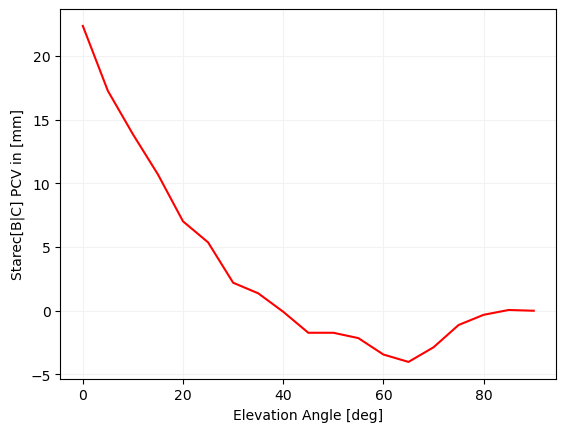

In [64]:
test_angles = np.arange(0e0, 90.5, .5) # 0, 0.5, 1.0, ...
pcv = [ starec_pcv(np.radians(a)) for a in test_angles ]
plt.plot(test_angles, pcv, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Starec[B|C] PCV in [mm]")
plt.xlabel(f"Elevation Angle [deg]")
ax = plt.gca()
plt.show()

rr_observed=-2149.303, rr_computed=-2146.693
rr_observed=-2116.394, rr_computed=-2113.784
rr_observed=-2083.136, rr_computed=-2080.524
rr_observed=-2049.606, rr_computed=-2046.995
rr_observed=-2015.732, rr_computed=-2013.119
rr_observed=-1981.593, rr_computed=-1978.978
rr_observed=-1947.107, rr_computed=-1944.494
rr_observed=-1912.362, rr_computed=-1909.748
rr_observed=-1877.279, rr_computed=-1874.664
rr_observed=-1841.933, rr_computed=-1839.323
rr_observed=-1806.263, rr_computed=-1803.649
rr_observed=-1770.338, rr_computed=-1767.723
rr_observed=-1734.086, rr_computed=-1731.471
rr_observed=-1697.585, rr_computed=-1694.973
rr_observed=-1660.770, rr_computed=-1658.155
rr_observed=-1623.713, rr_computed=-1621.097
rr_observed=-1586.342, rr_computed=-1583.728
rr_observed=-1548.740, rr_computed=-1546.125
rr_observed=-1510.835, rr_computed=-1508.220
rr_observed=-1472.704, rr_computed=-1470.087
rr_observed=-1434.278, rr_computed=-1431.663
rr_observed=-1395.635, rr_computed=-1393.019
rr_observe

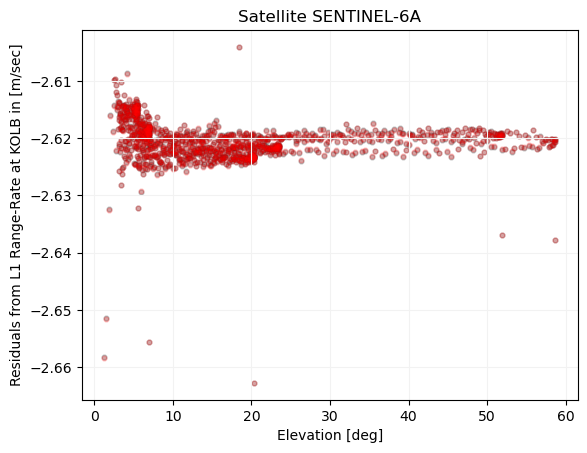

In [68]:
# Section 2.5 – Preprocess Doppler observations
#               Introduce PCO/PCV corrections
# ----------------------------------------------

# Helper variables to assist analysis
tai_prev = None     # time of last observation if any [TAI]
cp_prev = None      # Last carrier phase observation value (at tai_prev), [cycles]
dtropo_prev = None  # Last tropospheric correction [m]
rsat_prev = None    # Last satellite position, ECEF [m]
pass_nr = 0         # current pass index

# globals
CUTOFF_ANGLE = np.radians(1.) # cut-off angle in [deg]
C = 299792458e0 # speed of light in vacuum, [m/sec]

# nominal transmitting frequencies for selected beacon
# s1 -> 2GHz   channel
# u2 -> 400MHz channel
s1, u2 = beacon_nominal_frequency(rnx.kfactor(site_name))

# Nominal frequency for "Ionosphere-Free" linear combination
sqrt_gamma = s1 / u2
gamma = sqrt_gamma * sqrt_gamma
feN = frN = (gamma * s1 - sqrt_gamma * u2) / (gamma-1.)
# ... and a function to compute it based on the two channels
def iflc(L2ghz, L400mhz): return (gamma * L2ghz - sqrt_gamma * L400mhz) / (gamma-1.)
assert feN == frN

# Apply PCO corrections for the L_IF lin. combination
r_2GHz = np.array([0e0, 0e0, 487e-3])
r_400MHz = np.array([0e0, 0e0, 0e0])
rsta = rsta + transformations.geodetic2lvlh(lat, lon) @ (r_2GHz - r_400MHz) / (gamma-1.)

# store results here
residuals = []; epochs = []; elevations = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            # this is the actual epoch of observation
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # see if we have a new pass
            if tai_prev is None or (tai-tai_prev).total_seconds() > 200.:
                pass_nr += 1 if pass_nr > 0 else 0
            
            # Satellite position at signal emission time; store into an array
            satx, saty, satz, _ = intrp.sat_at(sat_id, tai)
            rsat = np.array([satx, saty, satz])

            # compute elevation
            _, _, el = transformations.azele(rsat, rsta)

            # only consider the observation if above cut-off angle
            if el >= CUTOFF_ANGLE:
                # compute a-priori tropospheric delay
                dtropo = vmf.tropo_delay(site_name, lat, lon, el, at2pt(tai))
    
                # Phase measurements at 2GHz carrier
                L2ghz = data['L1']['value']
                L400mhz = data['L2']['value']
                Lif = iflc(L2ghz, L400mhz)
    
                # apply frequency offset - get true receiver frequency
                frT = frN * (1 + data['F']['value'] * 1e-11)
    
                # if we have a previous measurement, within 10 sec ...
                if tai_prev is not None and (tai-tai_prev).total_seconds() <= 10.:
                    # delta time between this and previous obs, in [seconds]
                    dt = float((tai-tai_prev).total_nanoseconds()) * 1e-9
                    # measured part of the obs. equation
                    rr_observed = -(C / feN) * (feN - frT - (Lif-cp_prev)/dt)
                    # PCV corrections for this and previous measurements
                    pcv_now  = starec_pcv(el)*1e-3
                    pcv_prev = starec_pcv(el_prev)*1e-3
                    # computed part of the obs. equation
                    rr_computed = (np.linalg.norm(rsat-rsta) + pcv_now - np.linalg.norm(rsat_prev-rsta) - pcv_prev + (dtropo-dtropo_prev)) / dt
                    print(f'rr_observed={rr_observed:.3f}, rr_computed={rr_computed:.3f}')
                    # store results 
                    residuals.append(rr_observed-rr_computed)
                    epochs.append(tai)
                    elevations.append(el)

                # prepare for next measurement
                tai_prev = tai
                cp_prev = Lif
                dtropo_prev = dtropo
                rsat_prev = rsat
                el_prev = el

# Optional; remove outliers
residuals, epochs, elevations = filter_outliers(residuals, epochs, elevations)

print("Doppler Obs. Equation Residuals on the 2GHz Iono-Free Channel")
print("-------------------------------------------------------------")
print(f'Nominal frequencies S1={s1*1e-6:.1f}GHz (or {C/s1:.3f} m.), U2={u2*1e-3:.1f}MHz (or {C/u2:.3f} m.)')
print(f'Iono-Free LC frequency L3={feN*1e-6:.1f}GHz or {C/feN:.3f} m.')
print(f"Number of Doppler observations extracted: {len(residuals)}")
print(f"Residal mean value: {np.mean(residuals):.1f} and std. deviation = {np.std(residuals):.2f}")
plt.scatter([np.degrees(el) for el in elevations_sec24], residuals_sec24, alpha=0.2, s=12, c='black')
plt.scatter([np.degrees(el) for el in elevations], residuals, alpha=0.2, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")
plt.xlabel("Elevation [deg]")
# plt.ylim(2.6, 3.0)
plt.show()

# keep residuals for reference
residuals_sec25 = residuals; epochs_sec25 = epochs; elevations_sec25 = elevations;

### Offsets between Reference Points and Phase Centers On the Satellite Side

Offsets between reference points and phase centers do not only appear on the beacon side; they should also be treated correctly on the satellite side. Note that sp3 files contain tabulated positions of the satellite's Center of Mass, rather than a refernce point and/or phase center of the payload instrumentation. To correctly compute the offset between the DORIS receiver phase center and CoM, we need to know the satellite's **attitude** at each requested epoch, i.e. its orientation in a specific reference frame (normally an inertial one). Attitude can be computed either from what is called "phase law", i.e. predefined movements of the satellite depending on its position in the orbital plane and w.r.t the Sun, or by published, measured attitude (e.g. via Star Cameras).

Offsets at the satellite side will not be treated here, as attitude determination is a complex procedure that goes beyond the scope of the current lectures. Hence, this "error" will be left unmitigated, thus degrading accuracy. More information and satellite specific data can be found [here](https://ids-doris.org/documents/BC/satellites/DORISSatelliteModels.pdf).

```
16.1 MASS AND CENTER OF GRAVITY
// Mass (kg) // X cog (m) // Y cog (m) // Z cog (m) //
   1191.831     1.5274      -0.0073       0.0373

16.4 DORIS PHASE CENTERS
Position of DORIS 2GHz Phase center in satellite reference frame:
X (m) // Y (m) // Z (m) //
1.6251   0.3993   0.9972
Position of DORIS 400MHz phase center in satellite reference frame:
X (m) // Y (m) // Z (m) //
1.6251   0.3993   0.8282
```
Coordinates of reference points for the Sentinel-6 satellite as recorded in [DORIS satellites models implemented in POE processing](https://ids-doris.org/documents/BC/satellites/DORISSatelliteModels.pdf)

### [Skip? Optional] 2.6 Correction of Abberation or Signal Travel Time

$\rho _{1,2}$ is the geometric distance between the emitter at time $t_{1,2}$ and the receiver at time $t_{1,2}'$. Since the measurements are made by the receiver, only $t_{1,2}'$ is known. In order to compute $t_{1,2}$ and thus the position of the emitter at that time, a *correction of aberration* has to be performed. It is usually done in an iterative way (though one iteration is adequate for most cases). One can compute an approximate value of the emitter-receiver distance 
$\tilde{\rho}$ by evaluating the position of the emitter at time $t'$, then determining $t$ by applying the correction $t=t'-\tilde{\rho} / C$

At zenith, the signal has to travel about 1336km (i.e. $\approx$ Sentinel-6 altitude) which would mean a singal travel time of $\approx 4ms$. For an observation at the horizon (elevation angle is zero), the beacon-satellite distance would be $r = \sqrt((R_e + Altitude) - R_e) \approx 4332km$, giving a signal travel time of $\approx 14ms$

We can go on to compute the signal travel time for each observation ...

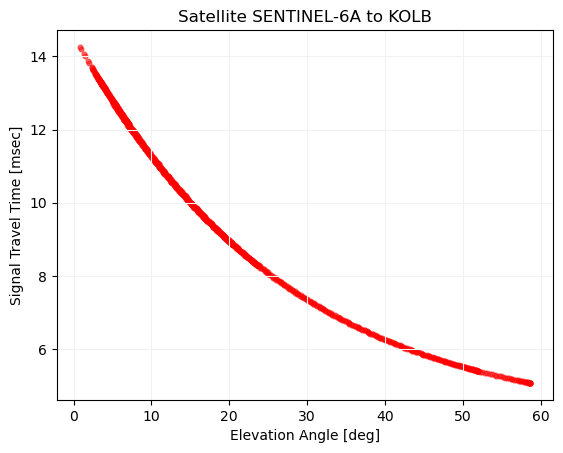

In [48]:
# globals
C = 299792458e0 # speed of light in vacum, [m/sec]

# store results here
trtime = []; elevations = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            # this is the actual epoch of observation
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)
            
            # Satellite position at signal emission time; store into an array
            satx, saty, satz, _ = intrp.sat_at(sat_id, tai)
            rsat = np.array([satx, saty, satz])

            # compute elevation
            _, _, el = transformations.azele(np.array([satx, saty, satz]), rsta)

            # store travel time and elevation
            travel_time = np.linalg.norm(rsat-rsta) / C
            trtime.append(travel_time)
            elevations.append(el)
                    

plt.scatter([np.degrees(e) for e in elevations], [t*1e3 for t in trtime], alpha=0.5, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Signal Travel Time [msec]")
plt.xlabel(f"Elevation Angle [deg]")
plt.title(f"Satellite {rnx.sat_name} to {site_name}")
plt.show()

In [49]:
def aberration(rsta, rsat, t_reception):
    MAX_ITERATIONS = 10
    # Earth's rotation rate in [rad/sec]
    omega = 7.2921150e-5
    Rsta = np.sqrt(rsta[0]*rsta[0]+rsta[1]*rsta[1])
    # iterate while there is no 'significant' change in beacon coordinates
    R = np.linalg.norm(np.array(rsta)-np.array(rsat))
    # approx travel time [sec]
    dt = R / C
    # approx correction in east direction
    deast_ang = dt * omega
    deast_lin = Rsta * deast_ang
    # print(f"East correction is {deast_lin:.3f} [m]")
    # corrected coordinates of beacon
    return rsta - transformations.geodetic2lvlh(lat, lon) @ np.array([deast_lin, 0e0, 0e0]) 

Doppler Obs. Equation Residuals on the 2GHz Iono-Free Channel
-------------------------------------------------------------
Nominal frequencies S1=2036.2GHz (or 0.147 m.), U2=401250.0MHz (or 0.747 m.)
Iono-Free LC frequency L3=2036.2GHz or 0.147 m.
Number of Doppler observations extracted: 1035
Residal mean value: -2.6 and std. deviation = 0.00


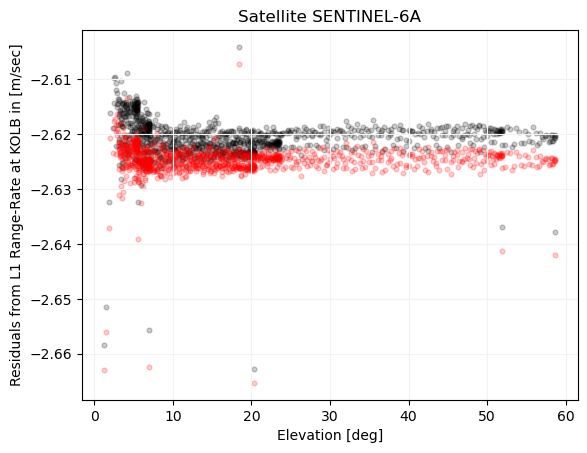

In [50]:
# Section 2.6 – Preprocess Doppler observations
#               model signal travel time
# --------------------------------------------------------

# Helper variables to assist analysis
tai_prev = None     # time of last observation if any [TAI]
cp_prev = None      # Last carrier phase observation value (at tai_prev), [cycles]
dtropo_prev = None  # Last tropospheric correction [m]
rsat_prev = None    # Last satellite position, ECEF [m]
pass_nr = 0         # current pass index

# globals
CUTOFF_ANGLE = np.radians(1.) # cut-off angle in [deg]
C = 299792458e0 # speed of light in vacuum, [m/sec]

# nominal transmitting frequencies for selected beacon
# s1 -> 2GHz   channel
# u2 -> 400MHz channel
s1, u2 = beacon_nominal_frequency(rnx.kfactor(site_name))

# Nominal frequency for "Ionosphere-Free" linear combination
sqrt_gamma = s1 / u2
gamma = sqrt_gamma * sqrt_gamma
feN = frN = (gamma * s1 - sqrt_gamma * u2) / (gamma-1.)
# ... and a function to compute it based on the two channels
def iflc(L2ghz, L400mhz): return (gamma * L2ghz - sqrt_gamma * L400mhz) / (gamma-1.)
assert feN == frN

# Apply PCO corrections for the L_IF lin. combination
r_2GHz = np.array([0e0, 0e0, 487e-3])
r_400MHz = np.array([0e0, 0e0, 0e0])
rsta = rsta + transformations.geodetic2lvlh(lat, lon) @ (r_2GHz - r_400MHz) / (gamma-1.)

# store results here
residuals = []; epochs = []; elevations = [];

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            # this is the actual epoch of observation
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # see if we have a new pass
            if tai_prev is None or (tai-tai_prev).total_seconds() > 300.:
                pass_nr += 1 if pass_nr > 0 else 0
            
            # Satellite position at signal reception time; store into an array
            satx, saty, satz, _ = intrp.sat_at(sat_id, tai)
            rsat = np.array([satx, saty, satz])

            # correct beacon crd for signal travel time
            rsta_now = aberration(rsta, rsat, tai)

            # compute elevation
            _, _, el = transformations.azele(rsat, rsta_now)

            # only consider the observation if above cut-off angle
            if el >= CUTOFF_ANGLE:
                # compute a-priori tropospheric delay
                dtropo = vmf.tropo_delay(site_name, lat, lon, el, at2pt(tai))
    
                # Phase measurements at 2GHz carrier
                L2ghz = data['L1']['value']
                L400mhz = data['L2']['value']
                Lif = iflc(L2ghz, L400mhz)
    
                # apply frequency offset - get true receiver frequency
                frT = frN * (1 + data['F']['value'] * 1e-11)
    
                # if we have a previous measurement, within 10 sec ...
                if tai_prev is not None and (tai-tai_prev).total_seconds() <= 10.:
                    # delta time between this and previous obs, in [seconds]
                    dt = float((tai-tai_prev).total_nanoseconds()) * 1e-9
                    # measured part of the obs. equation
                    rr_observed = -(C / feN) * (feN - frT - (Lif-cp_prev)/dt)
                    # PCV corrections for this and previous measurements
                    pcv_now  = starec_pcv(el)*1e-3
                    pcv_prev = starec_pcv(el_prev)*1e-3
                    # computed part of the obs. equation
                    rr_computed = (np.linalg.norm(rsat-rsta_now) + pcv_now - np.linalg.norm(rsat_prev-rsta_prev) - pcv_prev + (dtropo-dtropo_prev)) / dt
                    # store results 
                    residuals.append(rr_observed-rr_computed)
                    epochs.append(tai)
                    elevations.append(el)

                # prepare for next measurement
                tai_prev = tai
                cp_prev = Lif
                dtropo_prev = dtropo
                rsat_prev = rsat
                el_prev = el
                rsta_prev = rsta_now

# Optional; remove outliers
residuals, epochs, elevations = filter_outliers(residuals, epochs, elevations)

print("Doppler Obs. Equation Residuals on the 2GHz Iono-Free Channel")
print("-------------------------------------------------------------")
print(f'Nominal frequencies S1={s1*1e-6:.1f}GHz (or {C/s1:.3f} m.), U2={u2*1e-3:.1f}MHz (or {C/u2:.3f} m.)')
print(f'Iono-Free LC frequency L3={feN*1e-6:.1f}GHz or {C/feN:.3f} m.')
print(f"Number of Doppler observations extracted: {len(residuals)}")
print(f"Residal mean value: {np.mean(residuals):.1f} and std. deviation = {np.std(residuals):.2f}")
plt.scatter([np.degrees(el) for el in elevations_sec25], residuals_sec25, alpha=0.2, s=12, c='black')
plt.scatter([np.degrees(el) for el in elevations], residuals, alpha=0.2, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")
plt.xlabel("Elevation [deg]")
# plt.ylim(2.6, 3.0)
plt.show()

# keep residuals for reference
residuals_sec26 = residuals; epochs_sec26 = epochs; elevations_sec26 = elevations;

### [Skip? Experimental] L1/L2 Offset

Doppler Obs. Equation Residuals on the 2GHz Iono-Free Channel
-------------------------------------------------------------
Nominal frequencies S1=2036.2GHz (or 0.147 m.), U2=401250.0MHz (or 0.747 m.)
Iono-Free LC frequency L3=2102.3GHz or 0.143 m.
Number of Doppler observations extracted: 1035
Residal mean value: -2.6 and std. deviation = 0.01


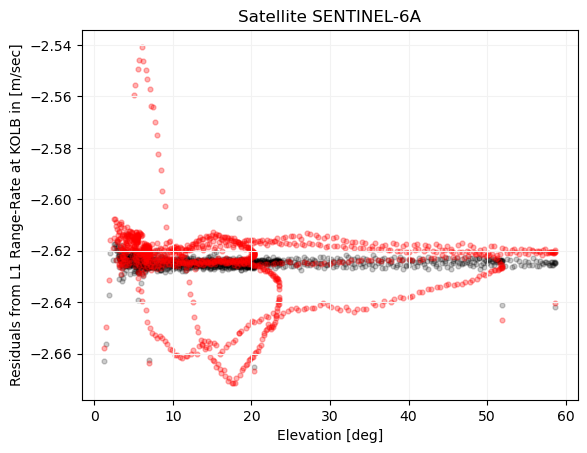

In [51]:
# Section 2.7 – Preprocess Doppler observations 
#               with L1/L2 offset
# --------------------------------------------------------

# Helper variables to assist analysis
tai_prev = None     # time of last observation if any [TAI]
cp_prev = None      # Last carrier phase observation value (at tai_prev), [cycles]
dtropo_prev = None  # Last tropospheric correction [m]
rsat_prev = None    # Last satellite position, ECEF [m]
pass_nr = 0         # current pass index

# globals
CUTOFF_ANGLE = np.radians(1.) # cut-off angle in [deg]
C = 299792458e0 # speed of light in vacuum, [m/sec]

# nominal transmitting frequencies for selected beacon
# s1 -> 2GHz   channel
# u2 -> 400MHz channel
s1, u2 = beacon_nominal_frequency(rnx.kfactor(site_name))

# Nominal frequency for "Ionosphere-Free" linear combination
sqrt_gamma = s1 / u2
gamma = sqrt_gamma * sqrt_gamma
feN = frN = (gamma * s1 - sqrt_gamma * u2) / (gamma-1.)
# ... and a function to compute it based on the two channels
def iflc(L2ghz, L400mhz): return (gamma * L2ghz - sqrt_gamma * L400mhz) / (gamma-1.)
feN = frN = (gamma*s1 - u2)/(gamma - 1.0)
def iflc(L2ghz, L400mhz): return (gamma*L2ghz - L400mhz)/(gamma - 1.0)
assert feN == frN

# Apply PCO corrections for the L_IF lin. combination
r_2GHz = np.array([0e0, 0e0, 487e-3])
r_400MHz = np.array([0e0, 0e0, 0e0])
rsta = rsta + (transformations.geodetic2lvlh(lat, lon)) @ (r_2GHz - r_400MHz) / (gamma-1.)

# store results here
residuals = []; epochs = []; elevations = [];

def interpolate_L2(t1, L2t1, t2, L2t2, hsec):
    def _unwrap_cycles(phi_prev, phi_curr):
        """Unwrap phase given in cycles across two samples."""
        # map cycles -> radians, unwrap, back to cycles
        vv = np.array([phi_prev*2*np.pi, phi_curr*2*np.pi], dtype=float)
        uu = np.unwrap(vv)
        return (uu[1] - uu[0])/(2*np.pi)
    """
    Linearly extrapolate L2 carrier phase (in cycles) from (t1, t2) to (t2 + h).
    Returns the phase at t2+h.
    """
    dt = float((t2-t1).total_nanoseconds()) * 1e-9
    if dt == 0:
        raise ValueError("t1 and t2 must be different")
    dphi = _unwrap_cycles(L2t1, L2t2)
    slope = dphi / dt # cycles per second
    return L2t2 + slope * hsec

# for every block in the RINEX file
for block in rnx:
    # for every beacon in the block
    for beacon, data in block:
        # match DIOB
        if beacon == rnx.name2id(site_name):
            
            # use the block-provided clock correction to get to (approximate) TAI
            # date(TAI) = epoch + receiver clock offset
            # this is the actual epoch of observation
            tai = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset() * 1e9)

            # see if we have a new pass
            if tai_prev is None or (tai-tai_prev).total_seconds() > 200.:
                pass_nr += 1 if pass_nr > 0 else 0
            
            # Satellite position at signal emission time; store into an array
            satx, saty, satz, _ = intrp.sat_at(sat_id, tai)
            rsat = np.array([satx, saty, satz])

            # compute elevation
            _, _, el = transformations.azele(rsat, rsta)

            # only consider the observation if above cut-off angle
            if el >= CUTOFF_ANGLE:
                # compute a-priori tropospheric delay
                dtropo = vmf.tropo_delay(site_name, lat, lon, el, at2pt(tai))
    
                # Phase measurements at 2GHz carrier
                L2ghz = data['L1']['value']
                L400mhz = data['L2']['value']
                Lif = iflc(L2ghz, L400mhz)

                # store previous L400MHz for interpolation
                L400mhz_prev = L400mhz
    
                # apply frequency offset - get true receiver frequency
                frT = frN * (1 + data['F']['value'] * 1e-11)
    
                # if we have a previous measurement, within 10 sec ...
                if tai_prev is not None and (tai-tai_prev).total_seconds() <= 10.:
                    # delta time between this and previous obs, in [seconds]
                    dt = float((tai-tai_prev).total_nanoseconds()) * 1e-9

                    # interpolate the L400MHz phase at tai + 
                    L400mhz = interpolate_L2(tai_prev, L400mhz_prev, tai, L400mhz, rnx.l2l1_date_offset)
                    Lif = iflc(L2ghz, L400mhz)
                    
                    # measured part of the obs. equation
                    rr_observed = -(C / feN) * (feN - frT - (Lif-cp_prev)/dt)
                    # PCV corrections for this and previous measurements
                    pcv_now  = starec_pcv(el)*1e-3
                    pcv_prev = starec_pcv(el_prev)*1e-3
                    # computed part of the obs. equation
                    rr_computed = (np.linalg.norm(rsat-rsta) + pcv_now - np.linalg.norm(rsat_prev-rsta) - pcv_prev + (dtropo-dtropo_prev)) / dt
                    # store results
                    residuals.append(rr_observed-rr_computed)
                    epochs.append(tai)
                    elevations.append(el)

                # prepare for next measurement
                tai_prev = tai
                cp_prev = Lif
                dtropo_prev = dtropo
                rsat_prev = rsat
                el_prev = el

# Optional; remove outliers
residuals, epochs, elevations = filter_outliers(residuals, epochs, elevations)
                    
print("Doppler Obs. Equation Residuals on the 2GHz Iono-Free Channel")
print("-------------------------------------------------------------")
print(f'Nominal frequencies S1={s1*1e-6:.1f}GHz (or {C/s1:.3f} m.), U2={u2*1e-3:.1f}MHz (or {C/u2:.3f} m.)')
print(f'Iono-Free LC frequency L3={feN*1e-6:.1f}GHz or {C/feN:.3f} m.')
print(f"Number of Doppler observations extracted: {len(residuals)}")
print(f"Residal mean value: {np.mean(residuals):.1f} and std. deviation = {np.std(residuals):.2f}")
plt.scatter([np.degrees(el) for el in elevations_sec26], residuals_sec26, alpha=0.2, s=12, c='black')
plt.scatter([np.degrees(el) for el in elevations], residuals, alpha=0.3, s=12, c='red')
plt.grid(color='0.95')
plt.ylabel(f"Residuals from L1 Range-Rate at {site_name} in [m/sec]")
plt.title(f"Satellite {rnx.sat_name}")
plt.xlabel("Elevation [deg]")
# plt.ylim(2.6, 3.0)
plt.show()

residuals_sec27 = residuals; epochs_sec27 = epochs; elevations_sec27 = elevations;